# Power Analysis for OCD Tractography Modeling

In this notebook, we consider a single example case: YBOCS as categorical response/nonresponse data across visits. We want to know: how big does the correlation between a single tract and the YBOCS response need to be before we can detect it?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
import sklearn as sklearn
import sklearn.ensemble
import sklearn.inspection
import scipy
from distfit import distfit
from pyglmnet import GLM
from imblearn.over_sampling import SMOTE

np.random.seed(55455)

In [41]:
# Re-load the dataset to get all subjects.
dat = pd.read_excel('/Users/alik/Documents/Research/Project Performance/StimVision OCD/2021 YBOCS Modeling Paper/DBS OCD Fiber Analysis August 2021 Cleaned For Distribution.xlsx')
#dat.describe()
#dat.columns

# Cells marked '0V' are where a stimulation was off. They capture 0 fibers in that tract, so this sets them to zeros.
dat = dat.mask(dat == '0V',other=0)

# Other things, like Peter comments, are stored as strings.
# Coerce the column to numeric, which turns strings into NaNs
number_cols = list(set(dat.columns) - set(['Subject','Date','Hypomanic']))
for c in number_cols:
        dat[c] = pd.to_numeric(dat[c],errors='coerce')
        
# Drop any column where there are >20% NaNs
for c in number_cols:
    if (sum(np.isnan(dat[c])) / dat[c].size) > 0.2 :
        dat = dat.drop(columns=c)
        
# Drop any row where there is no YBOCS response value
dat.dropna(subset = ['YBOCS_Response'],inplace=True)
        
# Convert hypomania to a boolean
dat["Hypomanic"] = (dat["Hypomanic"]=='Yes')
dat.describe()

print("The mean YBOCS drop, using each patient's best day, was ",
      np.mean(dat.loc[:,['Subject','YBOCS_Pct']].groupby('Subject').agg(np.max).values))

The mean YBOCS drop, using each patient's best day, was  46.59753325001837


In [173]:
# Control variables for the power simulation.
# More replicates and more steps = takes longer but nicer curves.
min_corr = 0
max_corr = 1.0
corr_step = 0.01
reps_per_corr_step = 100

In [174]:
# Helper function to extract core variables from a model and package things like the training/test sets for 
# future re-use.
def summarize_class_scores(model,test_X,test_Y,ModelType,SplitIdx):
    ret_frame = pd.DataFrame(index=[0])
    ret_frame['ModelType'] = ModelType
    ret_frame['SplitIdx'] = SplitIdx
    ret_frame['BalancedAccuracy'] = sklearn.metrics.balanced_accuracy_score(test_Y,model.predict(test_X))
    ret_frame['AUC'] = sklearn.metrics.roc_auc_score(test_Y,model.predict(test_X))
    ret_frame.loc[0,'AUC'] = max(ret_frame.loc[0,'AUC'],1-ret_frame.loc[0,'AUC'])
    
    # All of these are wrappers around things we'd need to re-run/re-calculate scores.
    ret_frame['Model'] = [[model]]   # This is buried in a list so we can use models of different types

    return ret_frame

In [175]:
# Perform the power simulation.

# Outer aggregation dataframe, for results of each replicate.
power_results = pd.DataFrame(columns=['TrueCorr','RepNum','AUC_Median','AUC_Lower','AUC_Upper','BAcc_Median','BAcc_Lower','BAcc_Upper',
                                      'Coeff_Median','Coeff_Lower','Coeff_Upper'],
                             dtype='object')

# Normalizer that we'll refit to each training set.
normalizer = sklearn.preprocessing.MinMaxScaler()

for true_corr in np.arange(min_corr,max_corr,corr_step):
    for rep_num in range(reps_per_corr_step):
        
        # Create simulated dataset.
        sim_dat = dat.loc[:,dat.columns.str.contains('Pct')].drop(columns=['YBOCS_Pct','MADRS_Pct'])   # All the percentage activations
        sim_dat.iloc[:,:] = np.random.random(sim_dat.shape) # Replace with random data
        sim_dat.loc[:,'R_Pct_T_ACC-PAC'] = sim_dat.loc[:,'R_Pct_T_ACC-PAC'] +  (dat.loc[:,'YBOCS_Response'] * true_corr)     # Make one column contain the correlation
        sim_dat = dat.loc[:,['Subject','YBOCS_Response']].join(sim_dat)   # Add back the grouping/Y-var info

        # Aggregator dataframe for results
        response_results = pd.DataFrame(columns=['SplitIdx','ModelType','Accuracy','BalancedAccuracy','Recall','AUC','Model','TrainIdx','TestIdx'],
                                              dtype='object')
        
        # SMOTE resampler to upsample and balance response/nonresponse
        sm = SMOTE(sampling_strategy='all',k_neighbors=3)

        # Cross-validation-splitter for leaving patients out
        split_idx = sklearn.model_selection.LeavePGroupsOut(n_groups=int(np.ceil(0.2*len(pd.Series.unique(sim_dat['Subject'])))))

        # Iterate over CV splits for this current simulated replicate.
        split_num=1
        
        response_groups = sim_dat["Subject"]
        response_X = sim_dat.drop(columns=['Subject','YBOCS_Response'])
        response_Y = sim_dat['YBOCS_Response']
        
        for train_idx,test_idx in split_idx.split(response_X,response_Y,response_groups):

            # Split the data according to this training/testing.
            clean_train_X = response_X.iloc[train_idx]
            clean_train_Y = response_Y.iloc[train_idx]

            clean_test_X = response_X.iloc[test_idx]
            clean_test_Y = response_Y.iloc[test_idx]

            # Fit a normalizer to the training set -- then scale both training AND test the same.
            # (It was already normalized, so this is a small shift, but it will ensure no variance leakage.)
            normalizer.fit(clean_train_X)
            clean_train_X = normalizer.transform(clean_train_X)
            clean_test_X = normalizer.transform(clean_test_X)

            # Upsample the training (NOT THE TEST) data with SMOTE
            resamp_X,resamp_Y = sm.fit_resample(clean_train_X,clean_train_Y)

            # This turns resamp_X into a np.array and we need to put it back
            resamp_X = pd.DataFrame(resamp_X)
            resamp_X.columns = response_X.columns

            resamp_Y = pd.Series(resamp_Y)
            resamp_Y.columns = ['YBOCS_Response']


            # Every so often, we get a test fold that doesn't have any TRUE responses. randomly flip one.
            if sum(clean_test_Y) == 0:
                clean_test_Y.iloc[np.random.randint(1,len(clean_test_Y))]=1

            # Fit L1 Penalized Logistic Regression - trying to shrink coefficients.
            # Fit on percentage only.
            mod_l1logit_Pct = sklearn.linear_model.LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l1',max_iter=1000).fit(resamp_X,resamp_Y)
            response_results = response_results.append(summarize_class_scores(mod_l1logit_Pct,clean_test_X,clean_test_Y,'L1Logistic_Pct',split_num),ignore_index=True,sort=False)


            # Store the train/test indexes. The call to tail() gets the rows we just filled. We need to pull their actual numeric index
            # in order to feed it to loc[] so we can then index the specific column.
            # And we wrap the relevant lists inside another list so that it all fits in one dataframe cell.
            # This is probably an abuse of dataframes.
            for j in response_results.tail(1).index:
                response_results.at[j,'TrainIdx'] = [train_idx]
                response_results.at[j,'TestIdx'] = [test_idx]

            # Move forward the CV iterator
            split_num = split_num+1
            
        # We have now done an exhaustive leave-two-out model fit on this replicate.
        # Summarize the results in terms of model statistics.
        model_grouped = response_results.groupby('ModelType').agg([np.median, 
                           lambda x: x.median() - (2*x.std()) ,
                           lambda x: x.median() + (2*x.std())]).rename(columns={'median':'median', '<lambda_0>' : 'CI_lower' , '<lambda_1>' : 'CI_upper'})
        
        # And pull the specific model coefficient for where we put the simulated correlation.
        ybocs_coef_agg = pd.DataFrame(columns=response_X.columns,dtype=float)
        for i in response_results.loc[response_results['ModelType'].str.contains('Logistic_Pct')].index :
            ybocs_coef_agg.loc[i,response_X.columns] = response_results.loc[i,'Model'][0].coef_[0]
        ybocs_coef_agg = pd.concat([ybocs_coef_agg.mean(),ybocs_coef_agg.std()],axis=1)
        ybocs_coef_agg.columns = ['CoeffMean','CoeffStd']

        # Append the summarized results to the aggregator (by first turning them into a dictionary)
        power_results = power_results.append({"TrueCorr":true_corr,
                                             'RepNum':rep_num+1,
                                               'AUC_Median':model_grouped['AUC']['median'].iloc[0],
                                              'AUC_Lower':model_grouped['AUC']['CI_lower'].iloc[0],
                                              'AUC_Upper':model_grouped['AUC']['CI_upper'].iloc[0],                                               
                                              'BAcc_Median':model_grouped['BalancedAccuracy']['median'].iloc[0],
                                              'BAcc_Lower':model_grouped['BalancedAccuracy']['CI_lower'].iloc[0],
                                              'BAcc_Upper':model_grouped['BalancedAccuracy']['CI_upper'].iloc[0],
                                               'Coeff_Median':ybocs_coef_agg.loc['R_Pct_T_ACC-PAC','CoeffMean'],
                                              'Coeff_Lower':ybocs_coef_agg.loc['R_Pct_T_ACC-PAC','CoeffMean'] - (2*ybocs_coef_agg.loc['R_Pct_T_ACC-PAC','CoeffStd']),
                                              'Coeff_Upper':ybocs_coef_agg.loc['R_Pct_T_ACC-PAC','CoeffMean'] - (2*ybocs_coef_agg.loc['R_Pct_T_ACC-PAC','CoeffStd'])
                                             },
                                            ignore_index=True)
        
# Uncomment this to see results
power_results

,TrueCorr,RepNum,AUC_Median,AUC_Lower,AUC_Upper,BAcc_Median,BAcc_Lower,BAcc_Upper,Coeff_Median,Coeff_Lower,Coeff_Upper
0,0.00,1.0,0.548148,0.380887,0.715410,0.491065,0.259392,0.722738,-0.082428,-0.653003,-0.653003
1,0.00,2.0,0.559626,0.400525,0.718727,0.546042,0.303407,0.788677,0.260138,-0.391137,-0.391137
2,0.00,3.0,0.542262,0.403447,0.681077,0.493400,0.289294,0.697506,-1.664049,-2.852240,-2.852240
3,0.00,4.0,0.625000,0.460736,0.789264,0.425126,0.171029,0.679223,-0.954235,-2.256980,-2.256980
4,0.00,5.0,0.562609,0.406245,0.718973,0.527143,0.273026,0.781259,0.209097,-0.601946,-0.601946
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.99,96.0,0.967256,0.658037,1.276475,0.967256,0.637539,1.296973,13.375858,11.633905,11.633905
9996,0.99,97.0,0.968182,0.666690,1.269673,0.968182,0.666690,1.269673,12.326187,11.099221,11.099221
9997,0.99,98.0,0.975694,0.684233,1.267155,0.975694,0.656527,1.294862,13.491565,11.501053,11.501053
9998,0.99,99.0,0.921218,0.640766,1.201671,0.921218,0.632732,1.209705,13.763644,12.037608,12.037608


In [176]:
# Aggregate these results by the true correlation.
power_results.loc[:,"AUC_Sig"] = power_results.loc[:,"AUC_Lower"] > 0.5
power_results.loc[:,"BAcc_Sig"] = power_results.loc[:,"BAcc_Lower"] > 0.5
power_results.loc[:,"Coeff_Sig"] = power_results.loc[:,"Coeff_Lower"] > 0

power_summary = power_results.loc[:,['TrueCorr','RepNum','AUC_Sig','BAcc_Sig','Coeff_Sig']].groupby("TrueCorr").agg(np.mean).drop(columns=['RepNum'])
power_summary

,AUC_Sig,BAcc_Sig,Coeff_Sig
TrueCorr,,,
0.00,0.00,0.0,0.04
0.01,0.03,0.0,0.06
0.02,0.00,0.0,0.09
0.03,0.01,0.0,0.09
0.04,0.00,0.0,0.08
...,...,...,...
0.95,1.00,1.0,1.00
0.96,1.00,1.0,1.00
0.97,1.00,1.0,1.00


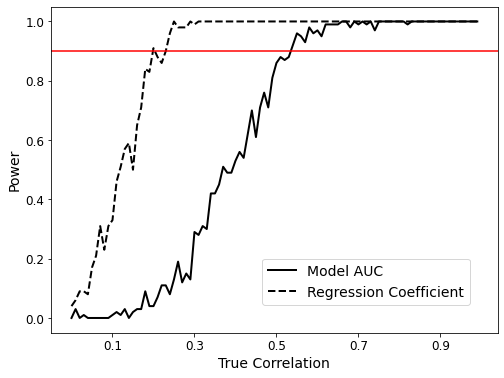

In [181]:
f1,a1 = plt.subplots(figsize=(8,6))
a1.plot(power_summary.index,power_summary['AUC_Sig'],'k-',
         power_summary.index,power_summary['Coeff_Sig'],'k--',
        linewidth=2)
a1.axhline(0.9,color='r')

trash = plt.xticks(np.arange(0.1,1.0,0.2))
trash = plt.setp(a1.get_xticklabels(),fontsize=12)
trash = plt.setp(a1.get_yticklabels(),fontsize=12)
trash = plt.xlabel('True Correlation',fontsize=14)
trash = plt.ylabel('Power',fontsize=14)
trash = plt.legend(['Model AUC','Regression Coefficient'],loc='lower right',borderaxespad=2,fontsize=14)

plt.savefig("YBOCS_Response_Power_Analysis",dpi=300)